In [1]:
import sys
sys.path.append('.')

from PIL import Image
import os
import base64
from io import BytesIO
from IPython.display import HTML
from pathlib import Path
from torchvision import transforms
from datetime import datetime
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import time
import torch
import pickle
from umap import UMAP
from hdbscan import HDBSCAN

/Users/edith/git/SurfaceAI/classification_models/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_90948/2482634484.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
config = {
    'root_path': str(Path().resolve() / ".." / ".."),
    'root_data': "data/training",
    'saving_root_path': "trained_models",
    'dataset': 'V11/scene_cropped/',
    'original_dataset': 'V11/annotated',
    'metadata_path': 'V11/metadata',
    'metadata_file': 'annotations_combined.csv',
    'embeddings_path': None,
    # 'embeddings_path': "embeddings/img_cropped_scene_embeddings_new_path.pkl",
    'embeddings_path': "embeddings/effnet_feature_embeddings.pkl",
    # 'embeddings_path': "embeddings/clip_embeddings.pkl",
}

# check possible hdbsacn_metric with:
# from sklearn import neighbors
# neighbors.BallTree.valid_metrics

# # Image embedding model
# embedding_model = config.get('embedding_model')

# # Image to text representation model
# representation_model = config.get('representation_model')

# images
root_path = config.get('root_path')
root_data = os.path.join(root_path, config.get('root_data'))
# root_dataset = os.path.join(root_data, config.get('dataset'))
root_orig_dataset = os.path.join(root_data, config.get('original_dataset'))
# saving_root_path = os.path.join(root_path, config.get('saving_root_path'))
# name = config.get("name", "")

# start_time = datetime.fromtimestamp(time.time()).strftime("%Y%m%d_%H%M%S")
# saving_name = name + "-" + start_time
# saving_path = os.path.join(saving_root_path, saving_name)

In [3]:
print(root_path)


/Users/edith/git/SurfaceAI/classification_models/src/utils/../..


In [4]:
if config.get('embeddings_path') is not None:
    with open(os.path.join(root_path, config.get('embeddings_path')), "rb") as f_in:
        data = pickle.load(f_in)
        images = data['images']
        embeddings = data['embeddings'].cpu().numpy()

In [5]:
# replace cropped images path with original non-cropped images path
original_images = [os.path.join(root_orig_dataset, old_path.split(config.get('dataset'))[-1]) for old_path in images]

print(images[:2])
print(original_images[:2])


['/home/edith/classification_models/data/training/V11/scene_cropped/asphalt/bad/1108901116248517.jpg', '/home/edith/classification_models/data/training/V11/scene_cropped/asphalt/bad/1132150697721186.jpg']
['/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/bad/1108901116248517.jpg', '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/bad/1132150697721186.jpg']


In [6]:
# define similarity measure
def cosine_similarity_manual(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def cosine_similarity_scripy(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

def cosine_similarity_sklearn(v1, v2):
    return cosine_similarity(v1, v2)

In [7]:
def find_image_index(image_id, images_path):
    ids = [os.path.splitext(os.path.split(path)[-1])[0] for path in images_path]
    return ids.index(image_id)

In [8]:
# define similarity search
def search_similarity(image_id, images_path, embeddings, k=np.inf, similarity_thresh=0.0):
    idx = find_image_index(image_id=image_id, images_path=images_path)
    image_embedding = embeddings[idx]

    similar_images = []
    for i, embedding in enumerate(embeddings):
        similarity_value = cosine_similarity_manual(image_embedding, embedding)
        if similarity_value >= similarity_thresh:
            similar_images.append({'image': images_path[i], 'similarity': similarity_value})
            similar_images = sorted(similar_images, key=lambda o: o['similarity'], reverse=True)
            if len(similar_images) > k:
                similar_images = similar_images[:k]

    return similar_images

In [9]:
# define html image visualization
def html_image(similar_images):

    html_content = '<div style="display:grid; grid-template-columns: repeat(3, 2fr); grid-gap: 2px;">'

    for item in similar_images:
        image_path = item['image']
        sim_score = f"Score: {item['similarity']:.4f}"

        with open(image_path, 'rb') as f:
            image_data = f.read()
            # print(type(image_data)) # --><class 'bytes'>
            encoded_image = base64.b64encode(image_data).decode('utf-8')
            # print(type(encoded_image)) # --> str
            #image_data = custom_crop(image_data, crop_style="lower_middle_third")

            labels = os.path.splitext(os.path.split(image_path)[-1])[0]

        image_html = (
            f"<div>"
            f"<img src='data:image/jpeg;base64,{encoded_image}' style='width:400px;height:300px;'>"
            f"<p>{sim_score}</p>"
            f"<p>{labels}</p>"
            f"</div>"
        )
        html_content += image_html
    html_content += '</div>'

    # Display HTML content in thea Jupyter Notebook
    display(HTML(html_content))

In [15]:
image_id = '236970119443815'
image_id = '1316011592154091'
similar_images = search_similarity(image_id, original_images, embeddings, k=30, similarity_thresh=0.6)

In [16]:
idx1 = find_image_index(image_id='390621922031094', images_path=original_images)
image_embedding1 = embeddings[idx1]
idx2 = find_image_index(image_id='1316011592154091', images_path=original_images)
image_embedding2 = embeddings[idx2]
cosine_similarity_manual(image_embedding1, image_embedding2)

0.35859254

In [17]:
similar_images

[{'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/1316011592154091.jpg',
  'similarity': 1.0},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/527538271870848.jpg',
  'similarity': 0.7402242},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/good/522849042171835.jpg',
  'similarity': 0.7188418},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/good/5460023094086009.jpg',
  'similarity': 0.70630693},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/revise/1135329496995593.jpg',
  'similarity': 0.70059747},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/intermediate/1139821286514719.jpg',
  'simil

In [18]:
len(similar_images)

30


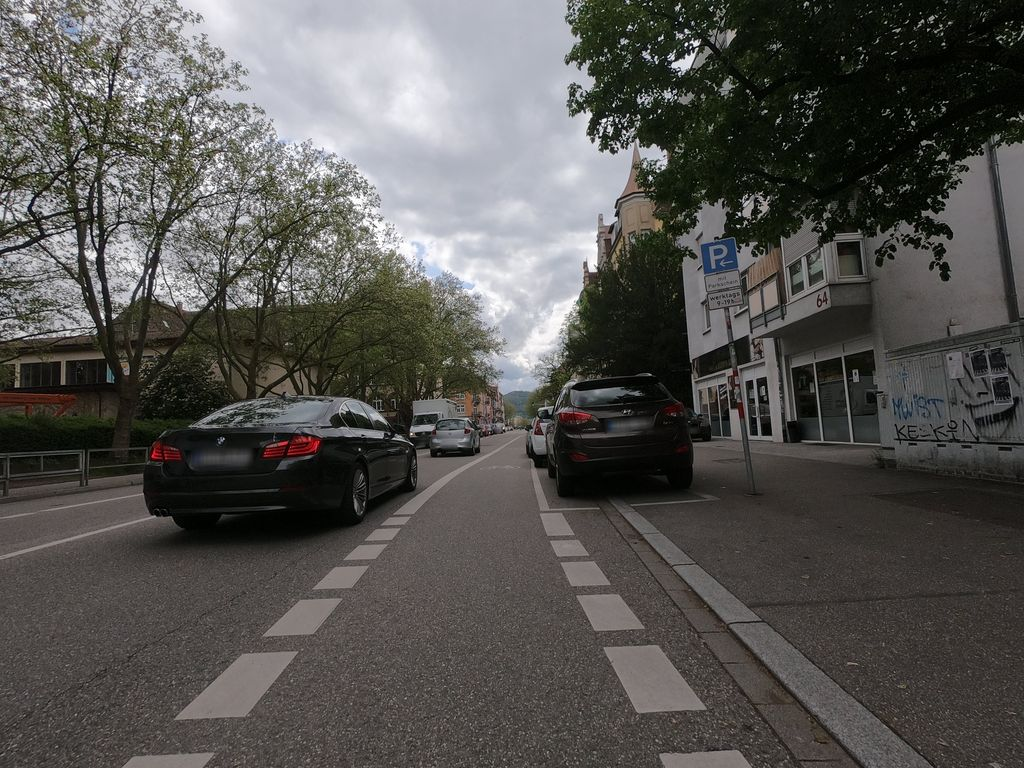
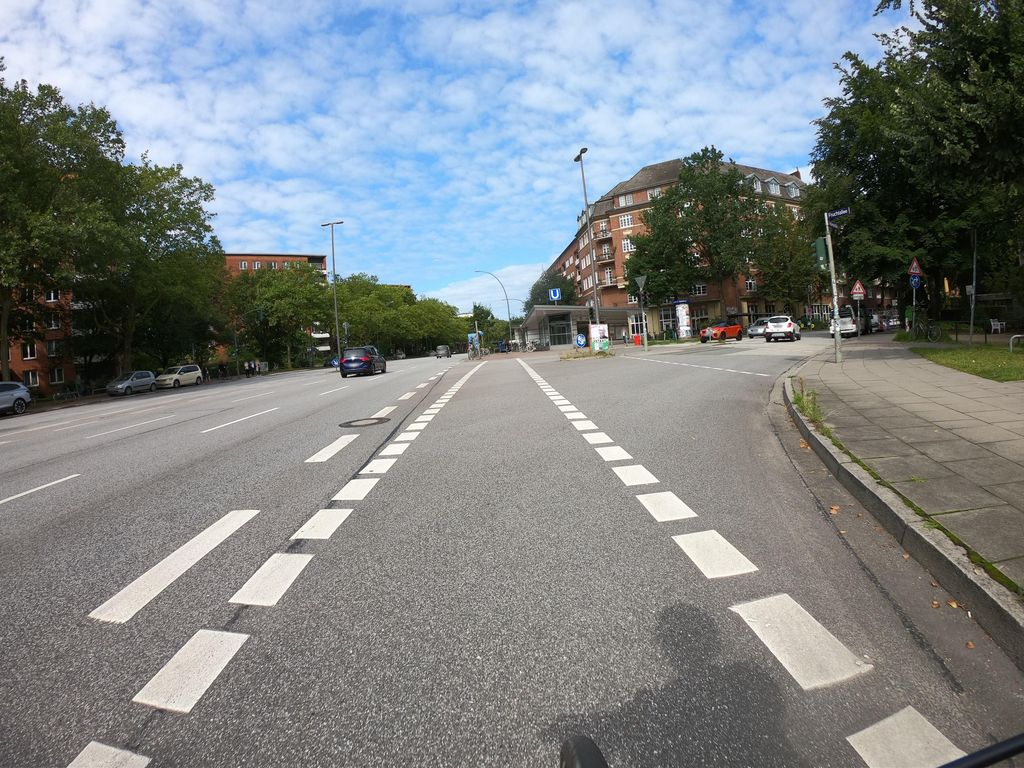
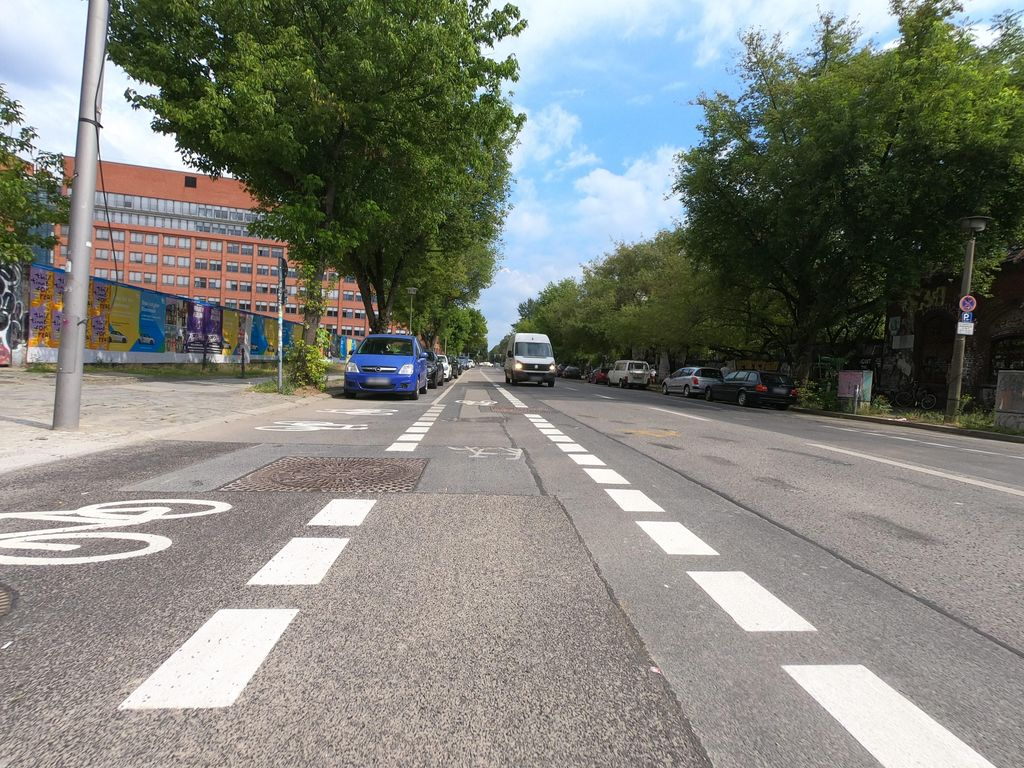
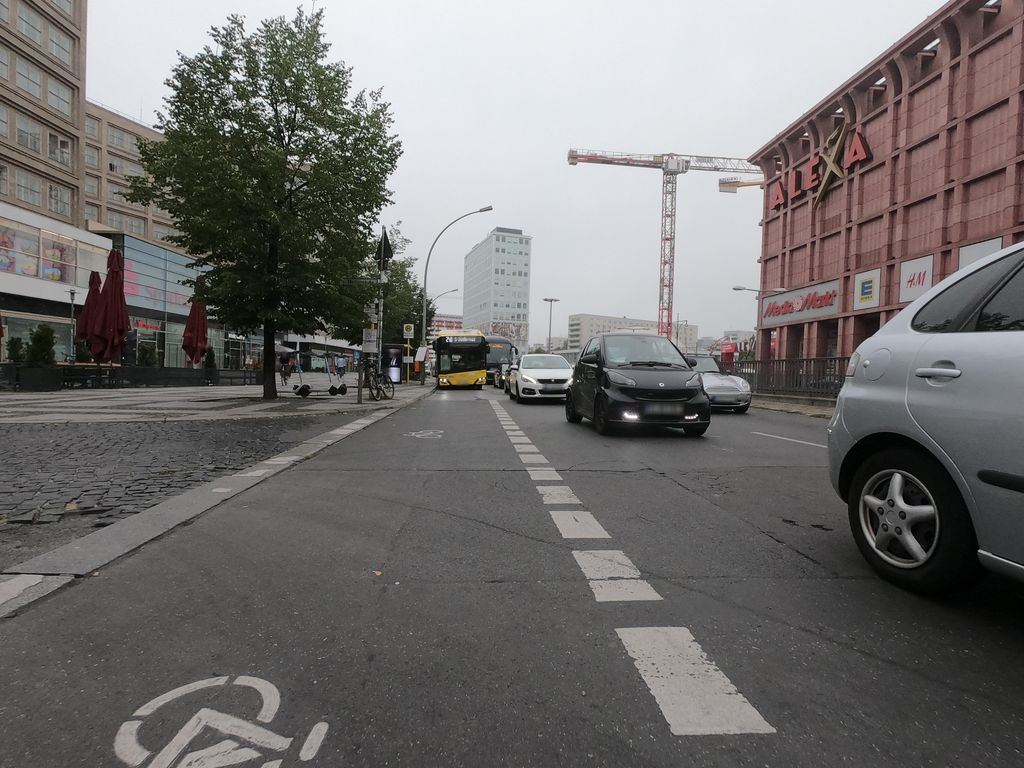
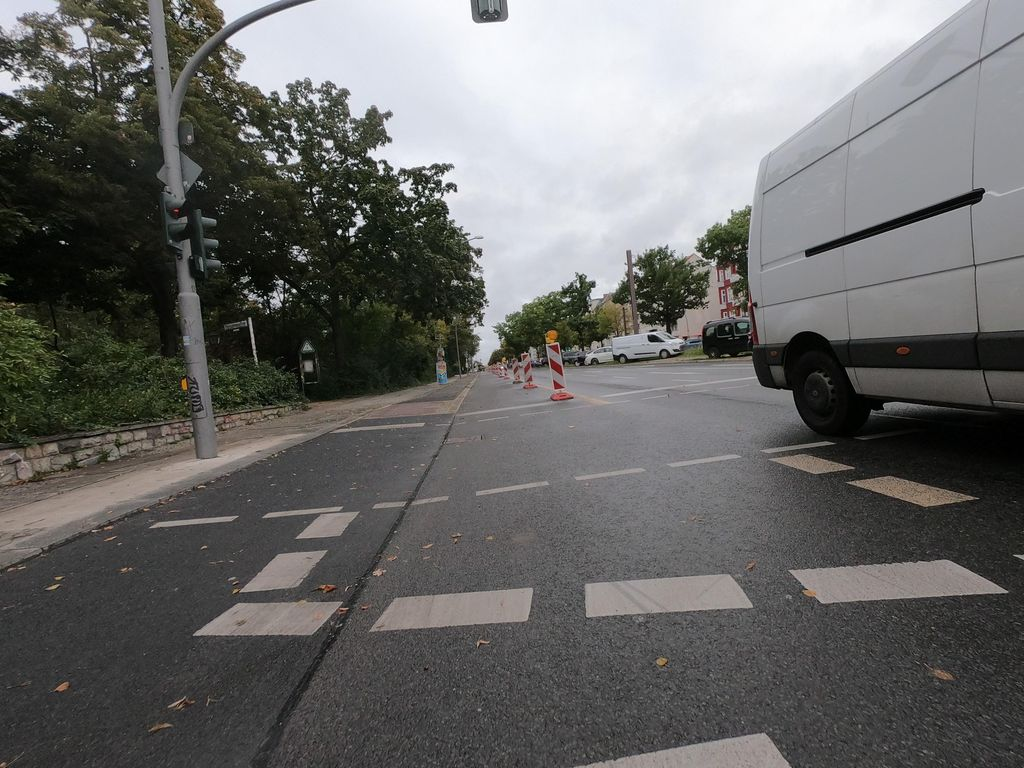
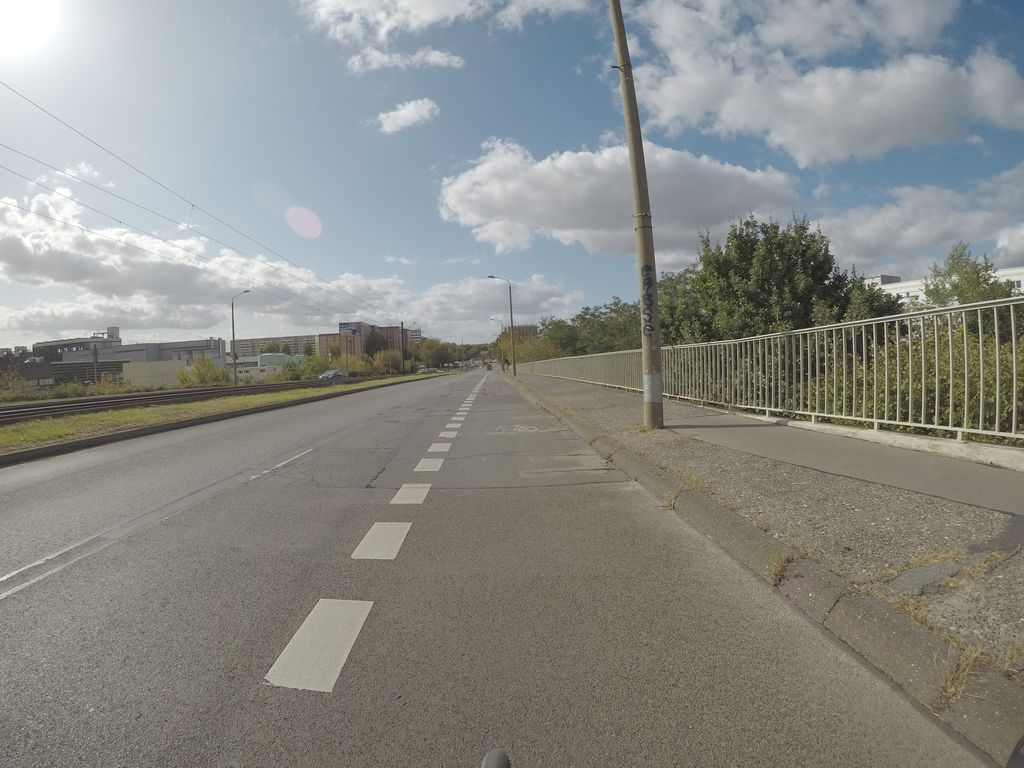
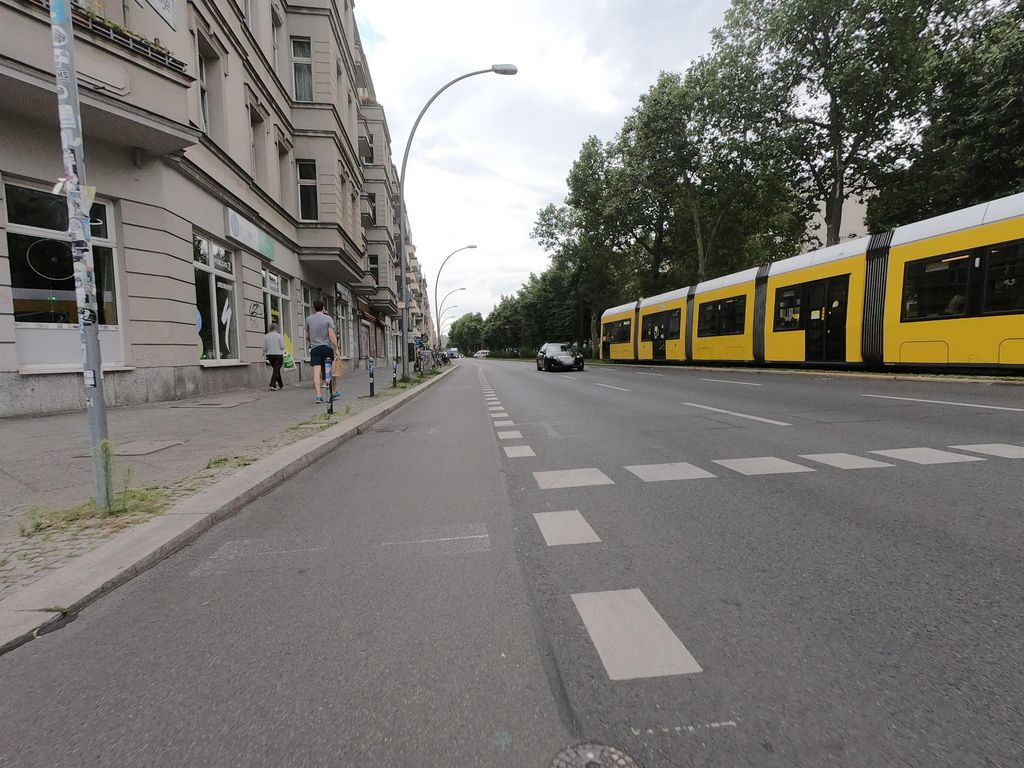
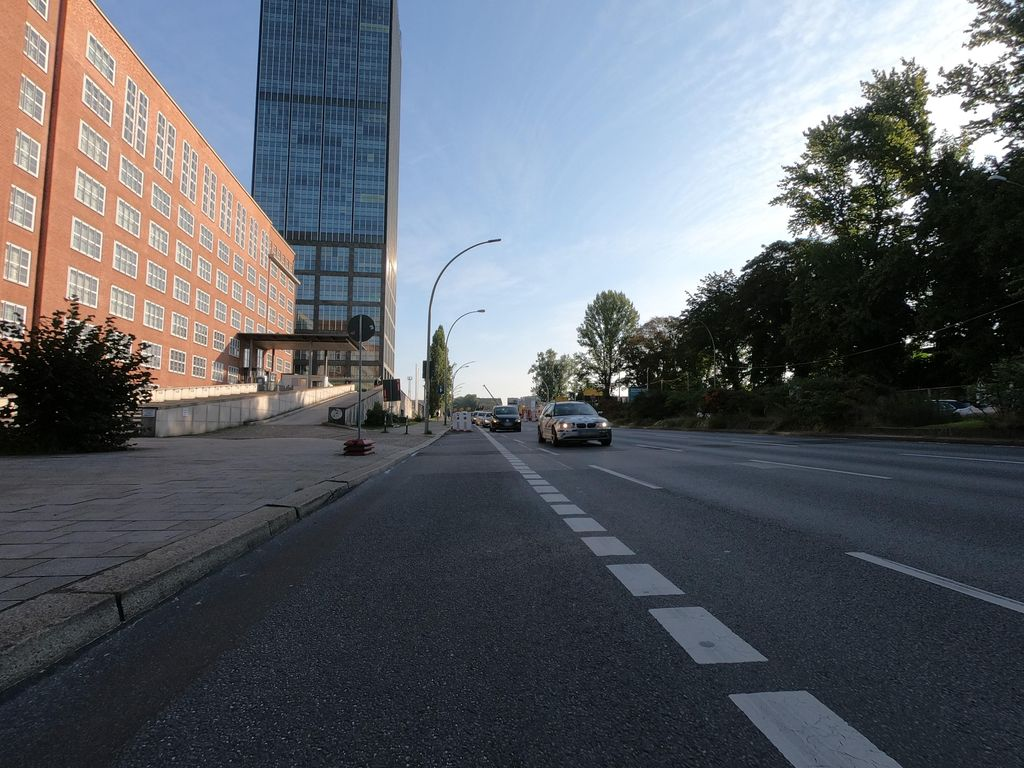
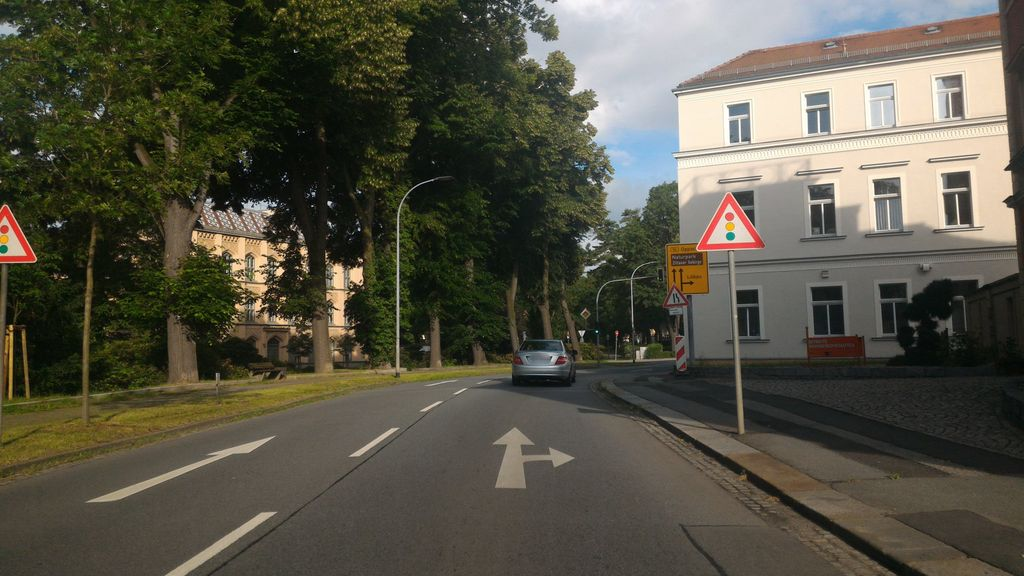
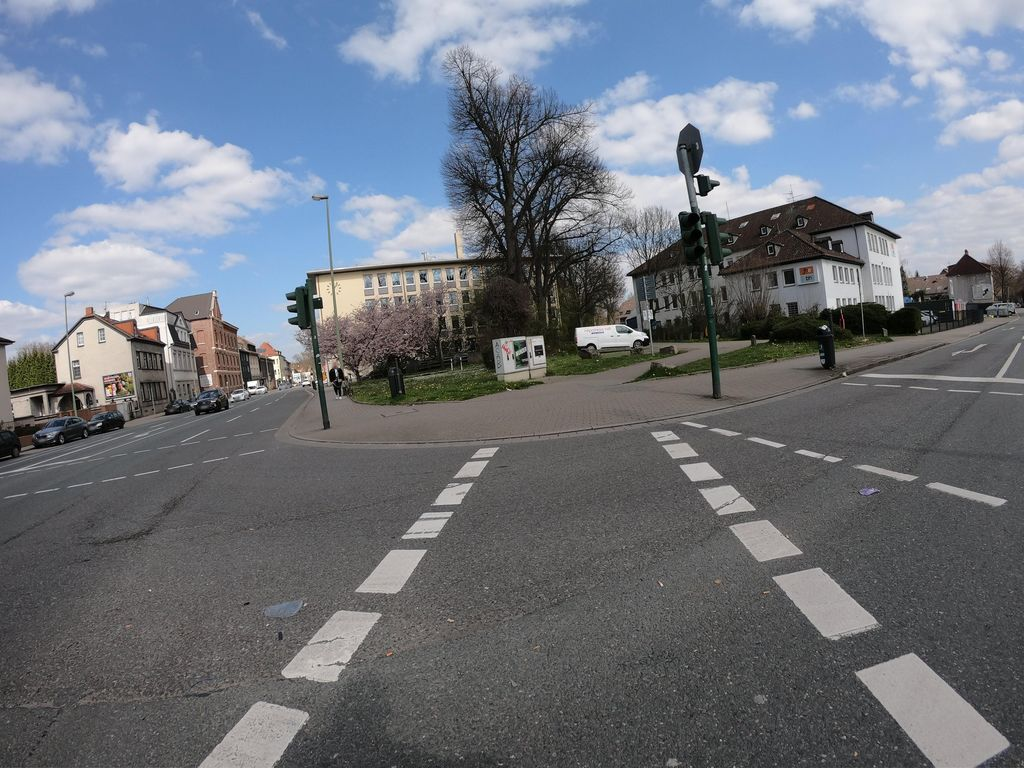
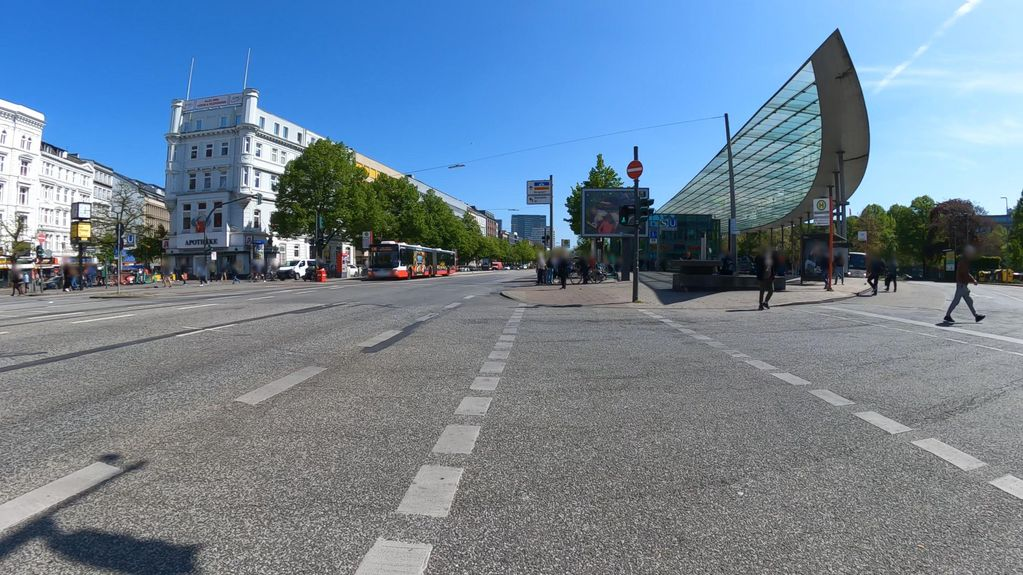
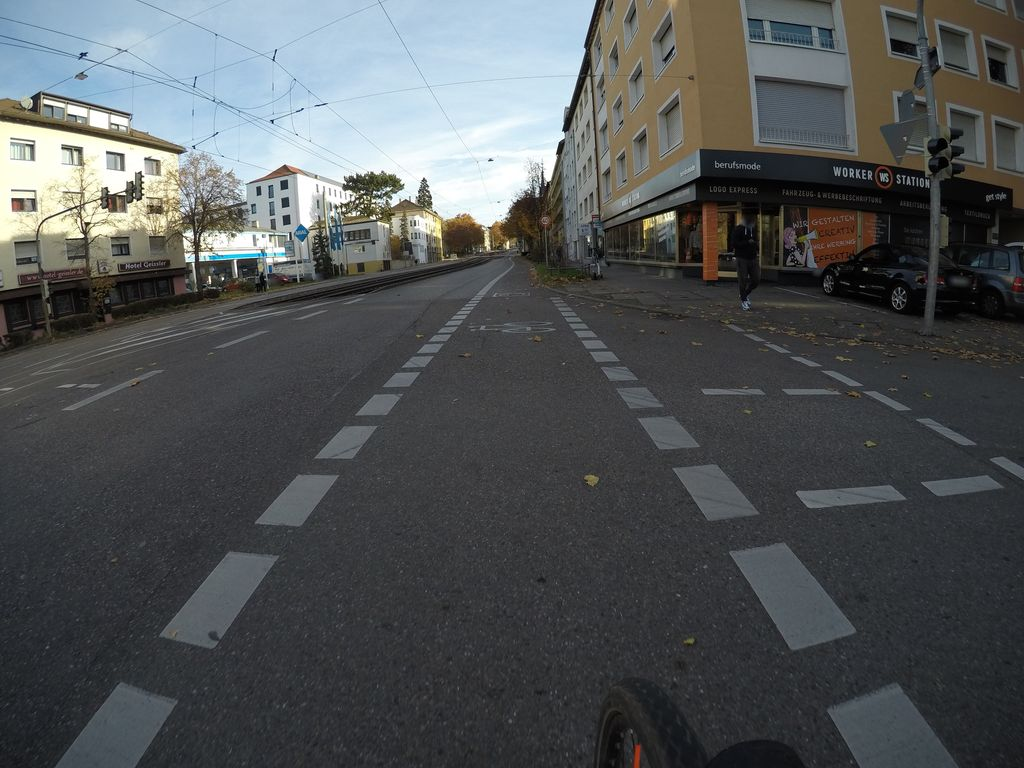
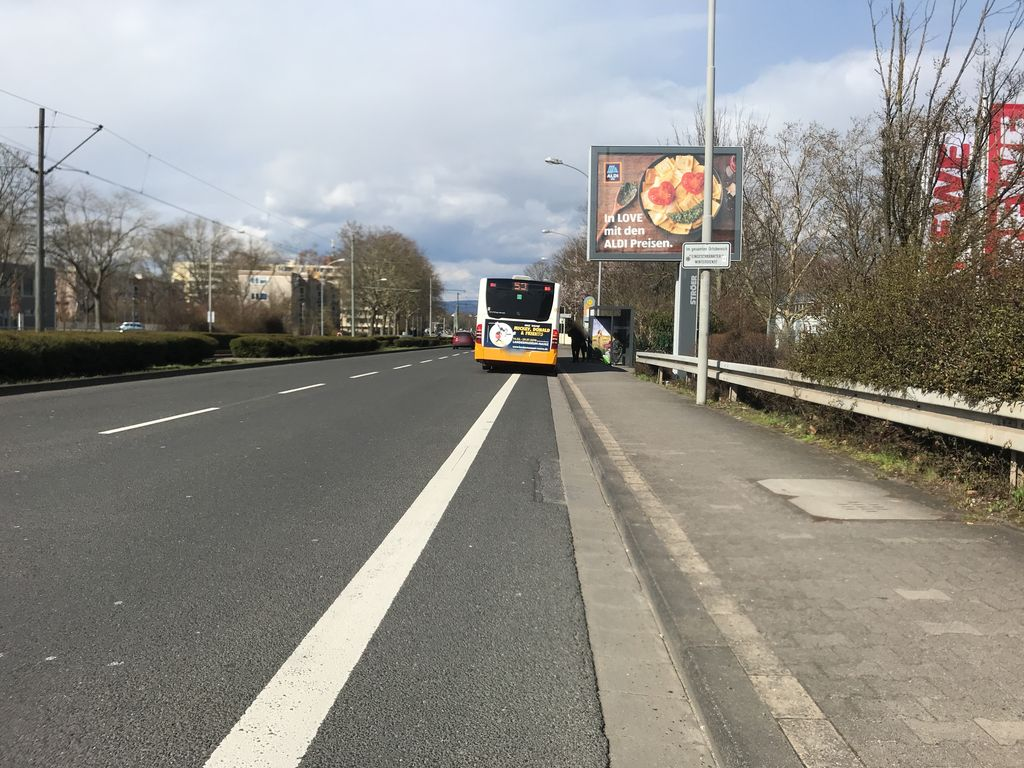
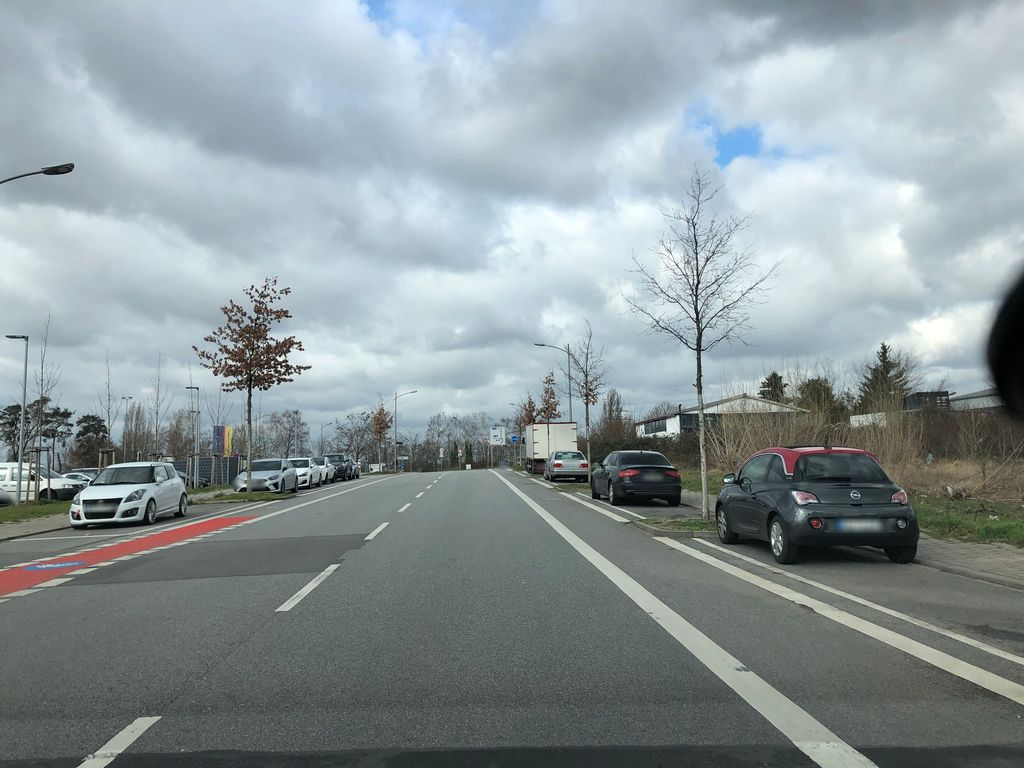
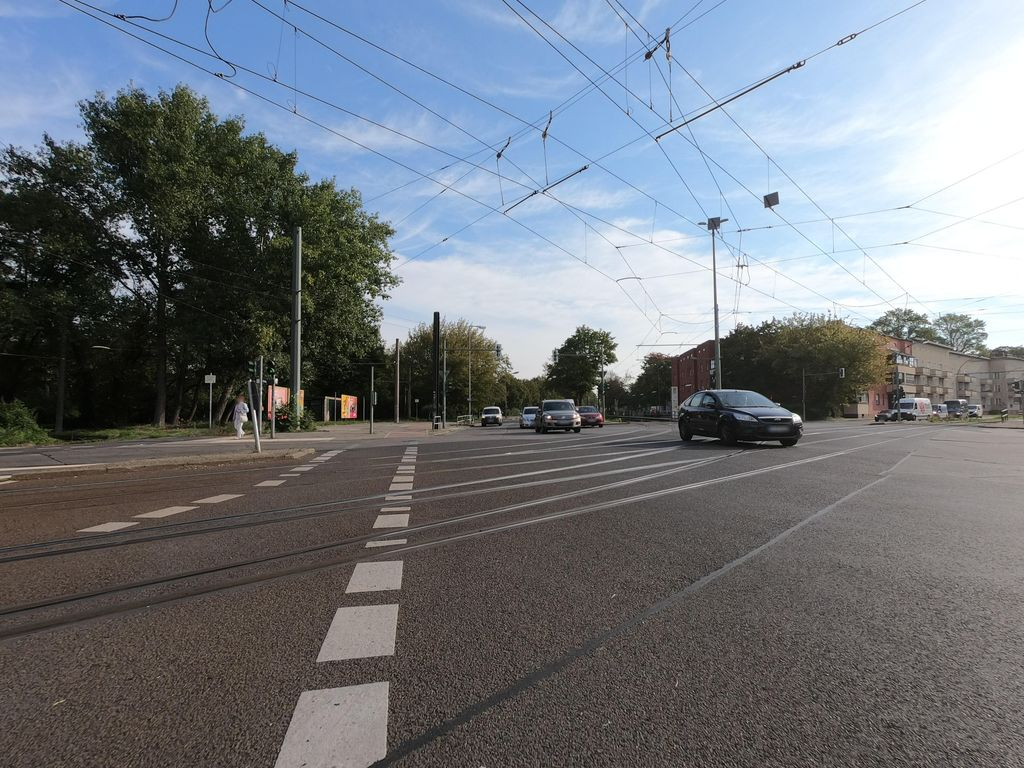
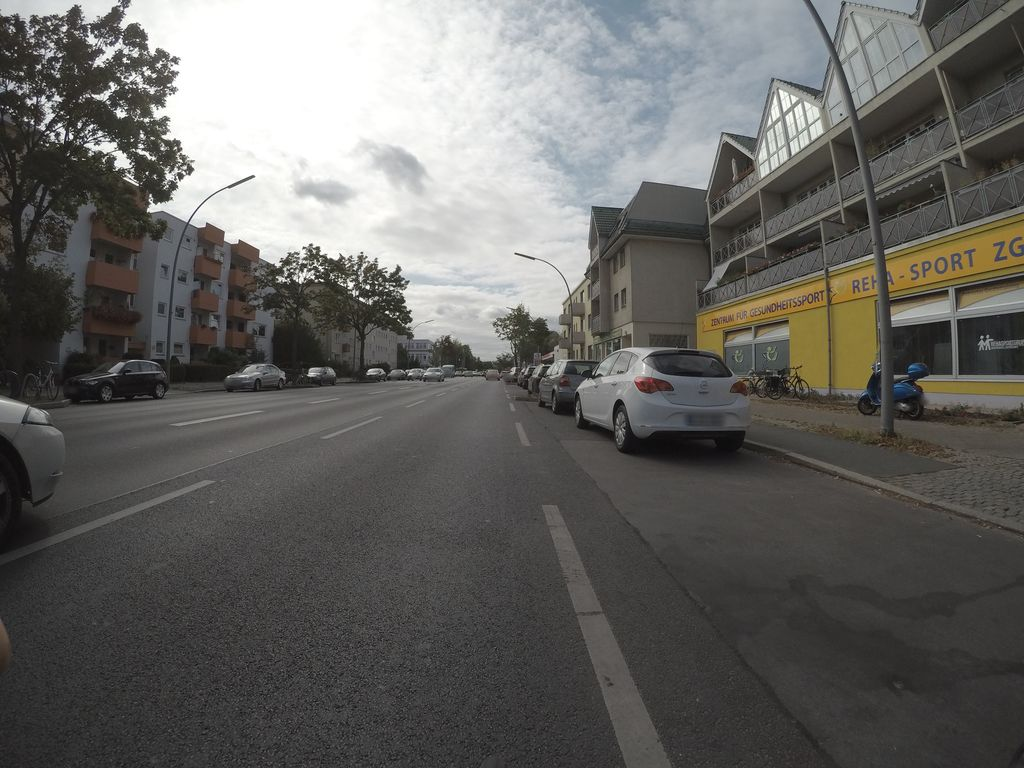
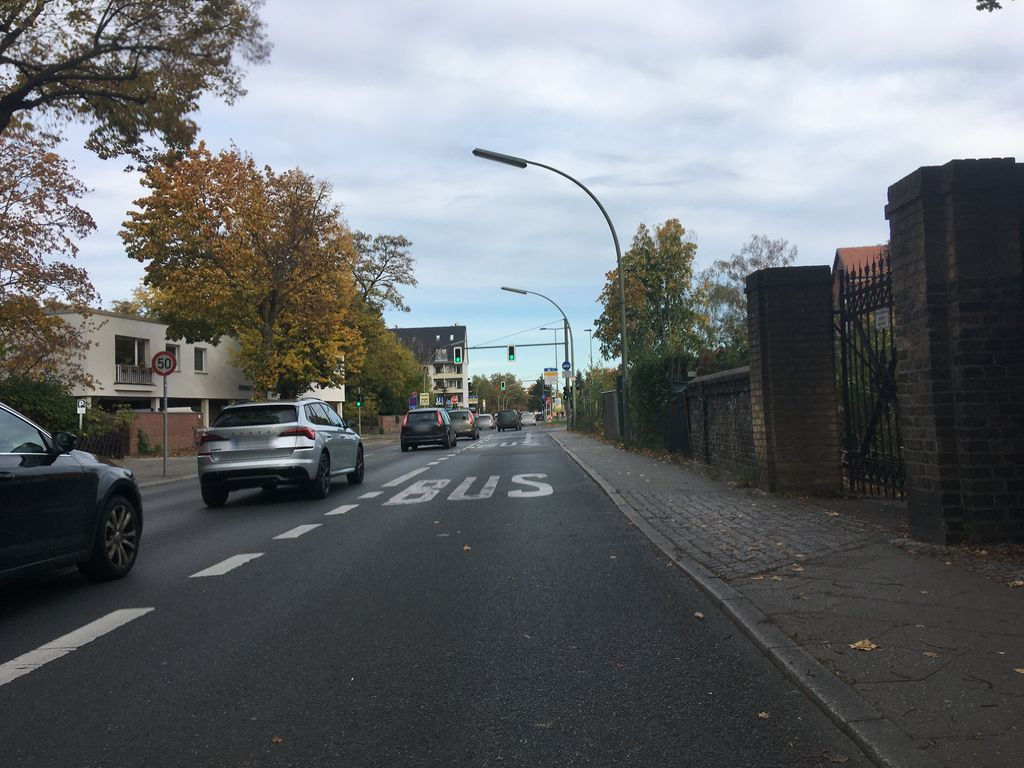
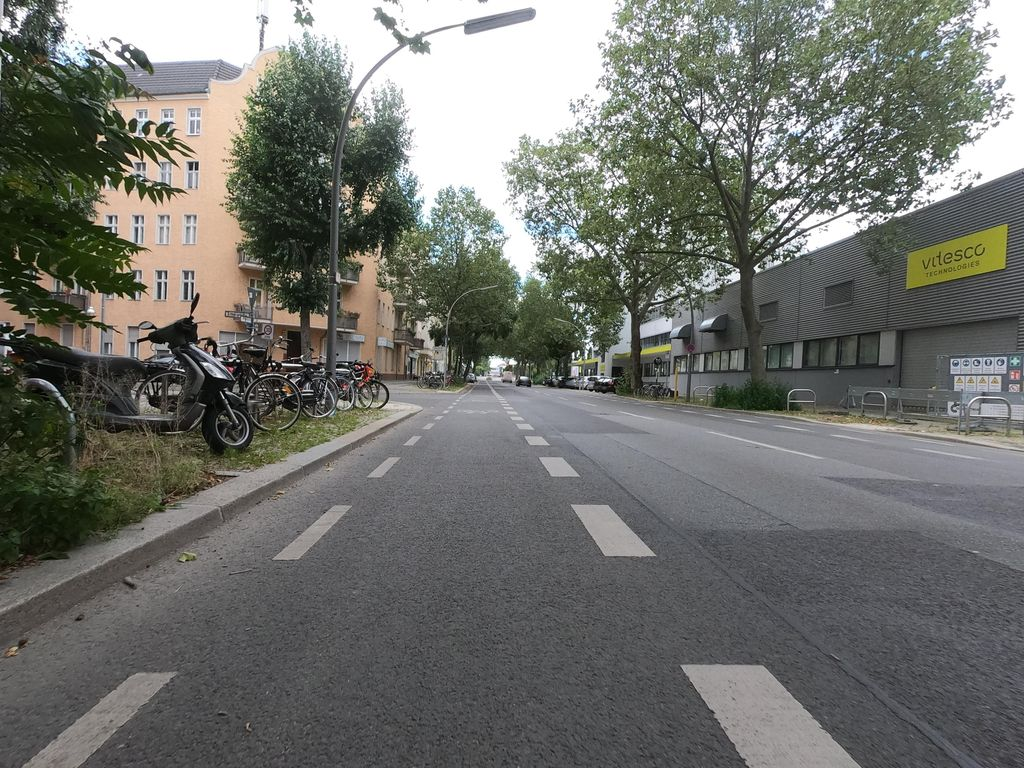
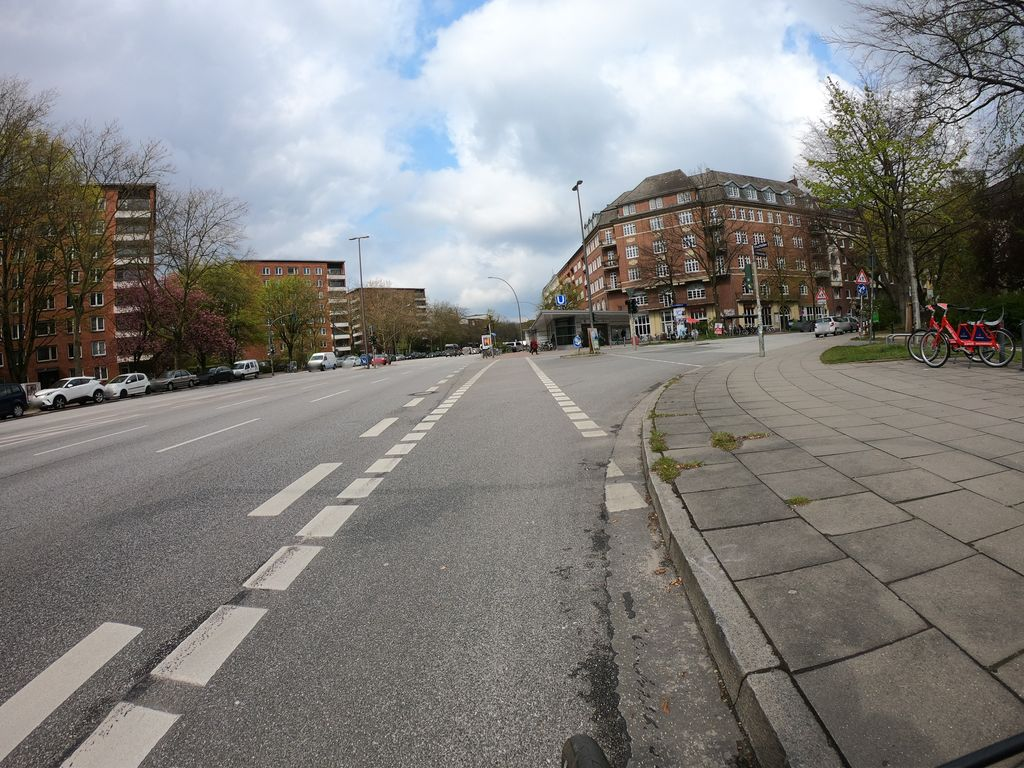
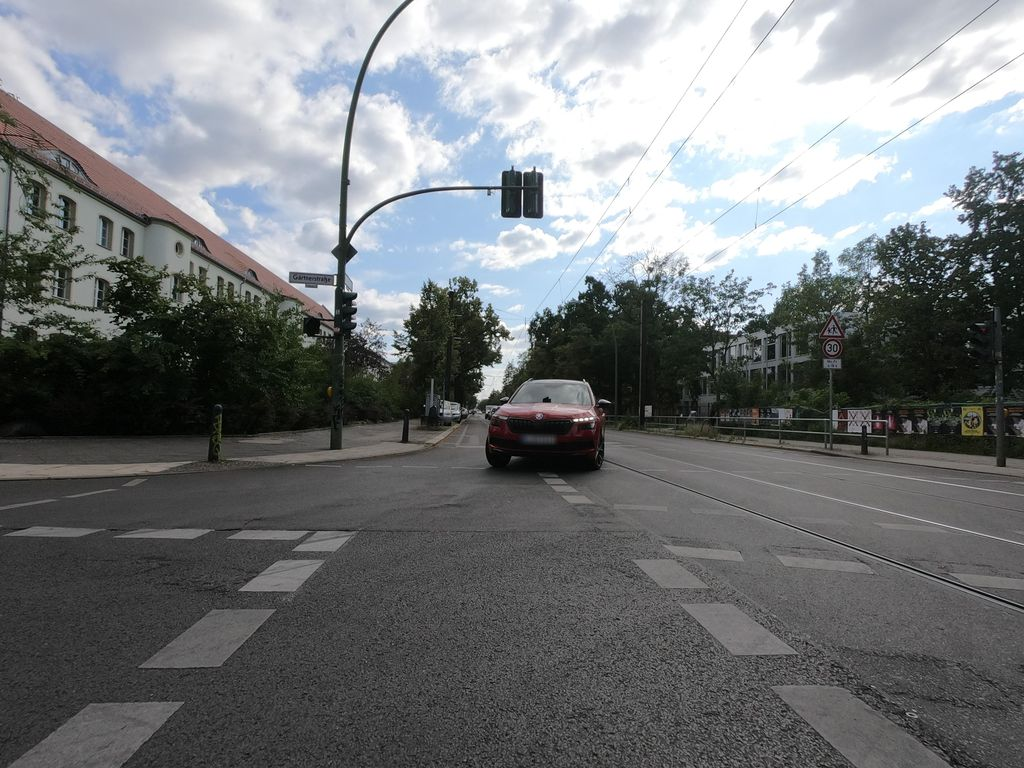
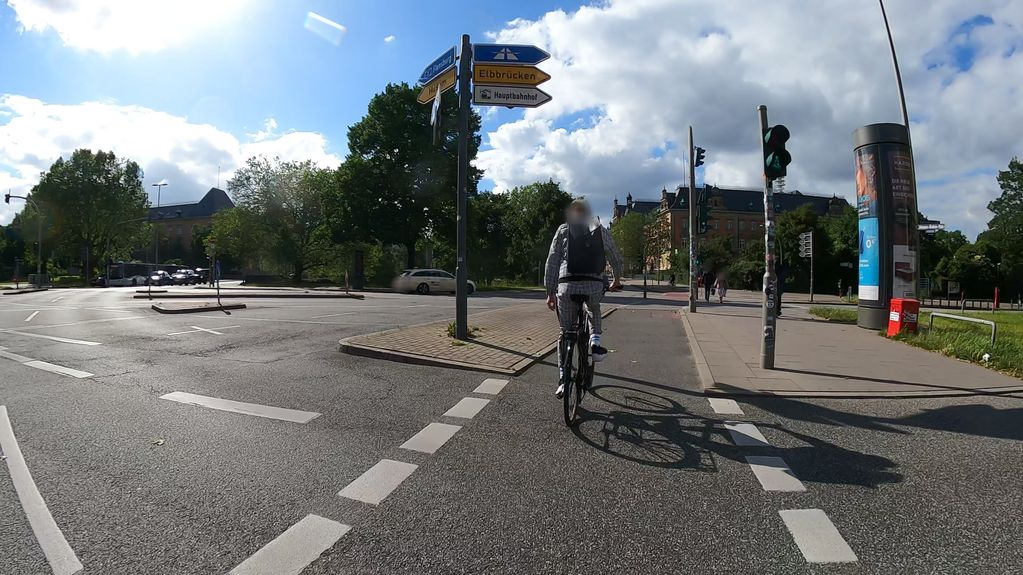
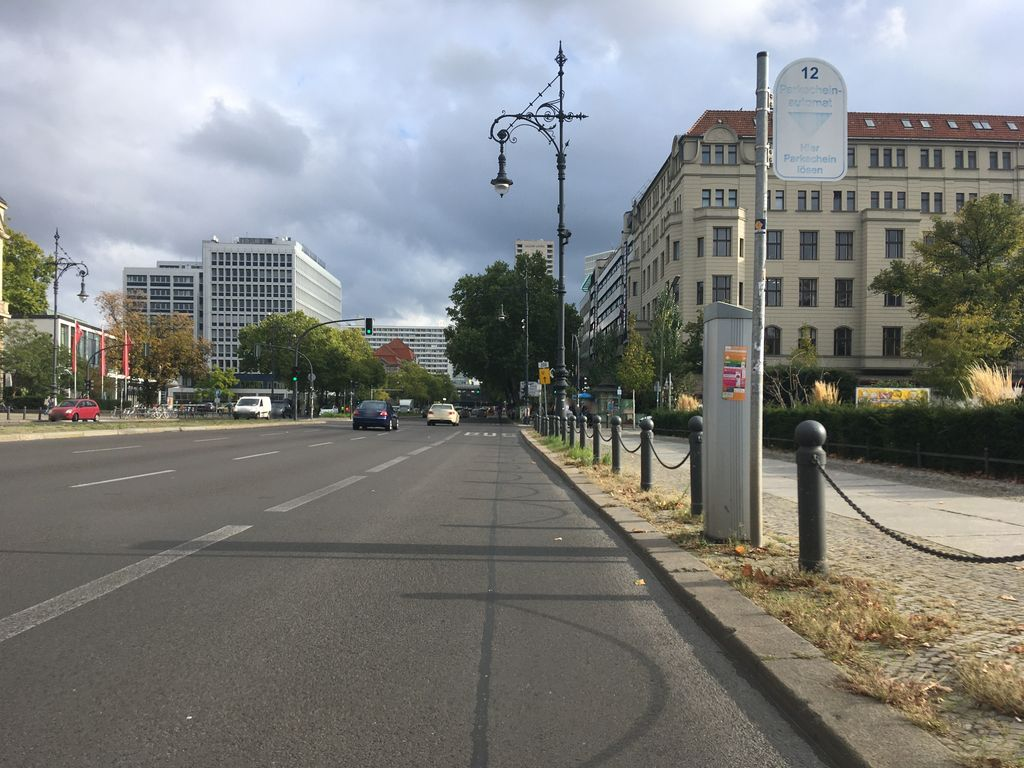
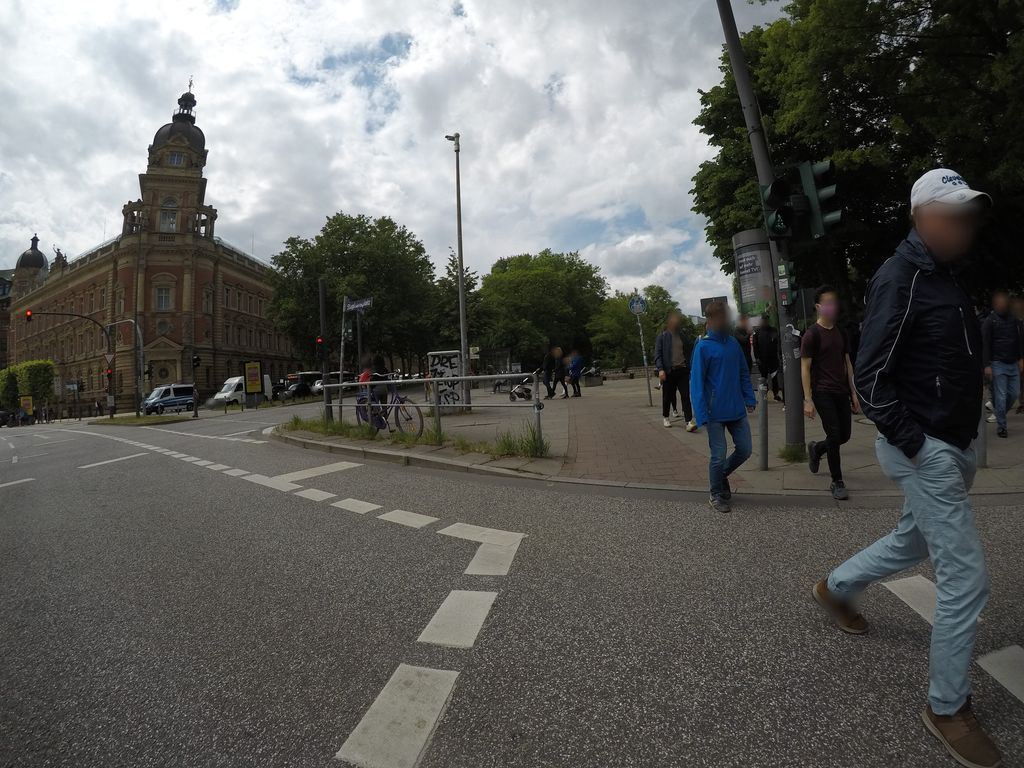
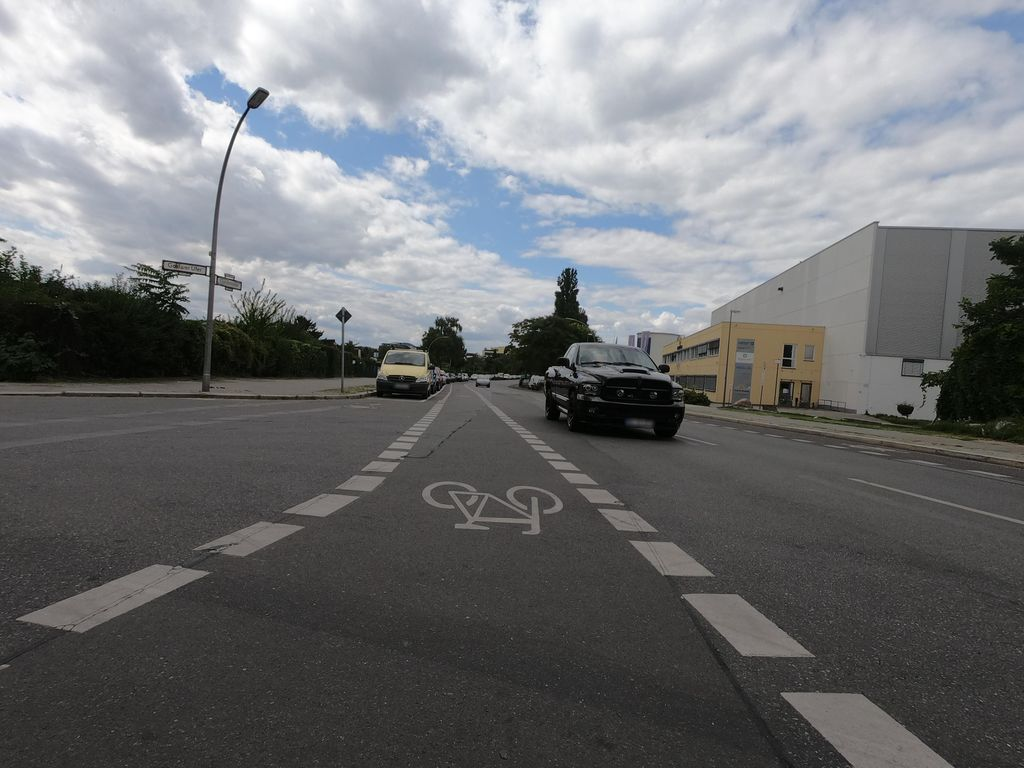
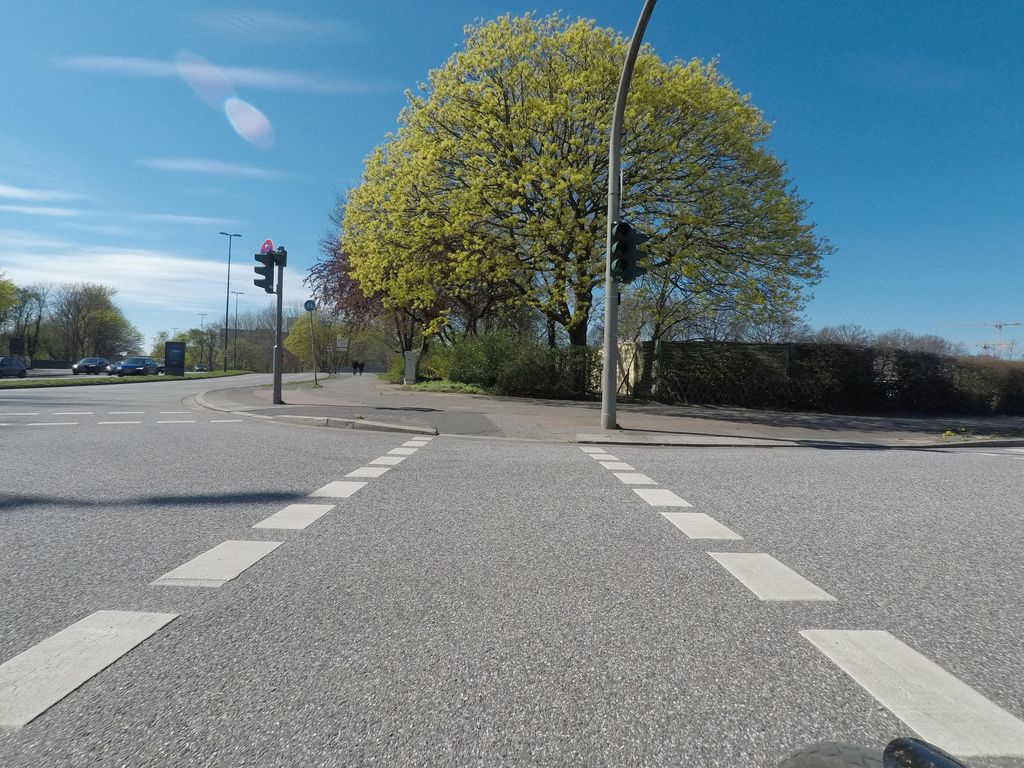
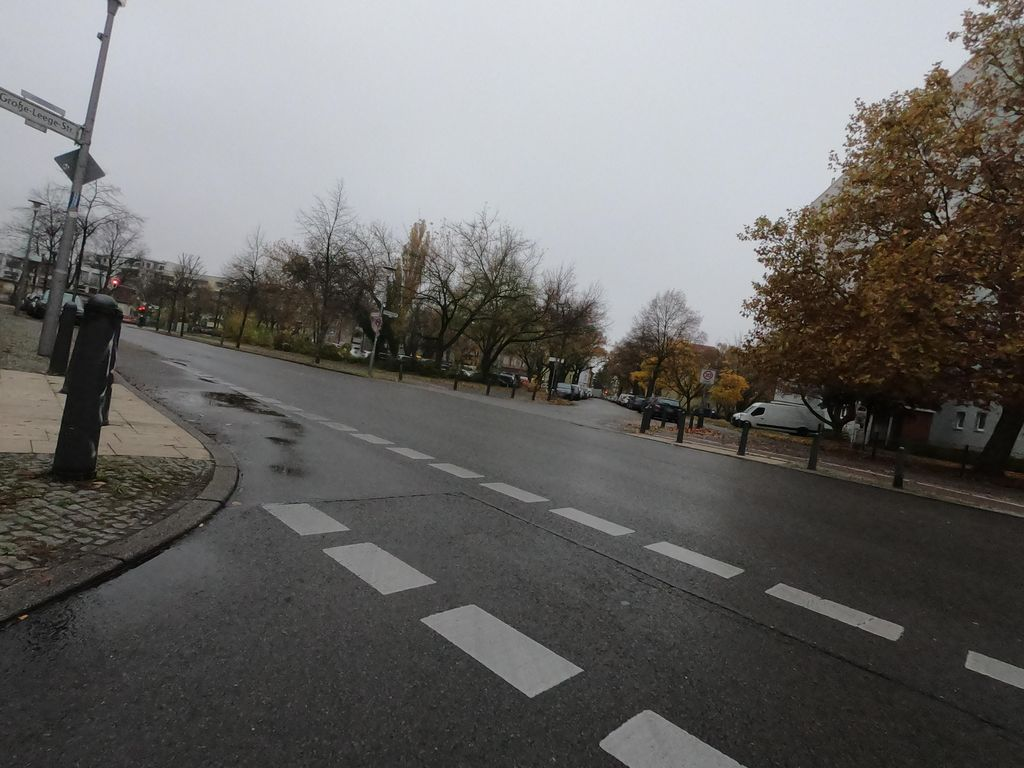
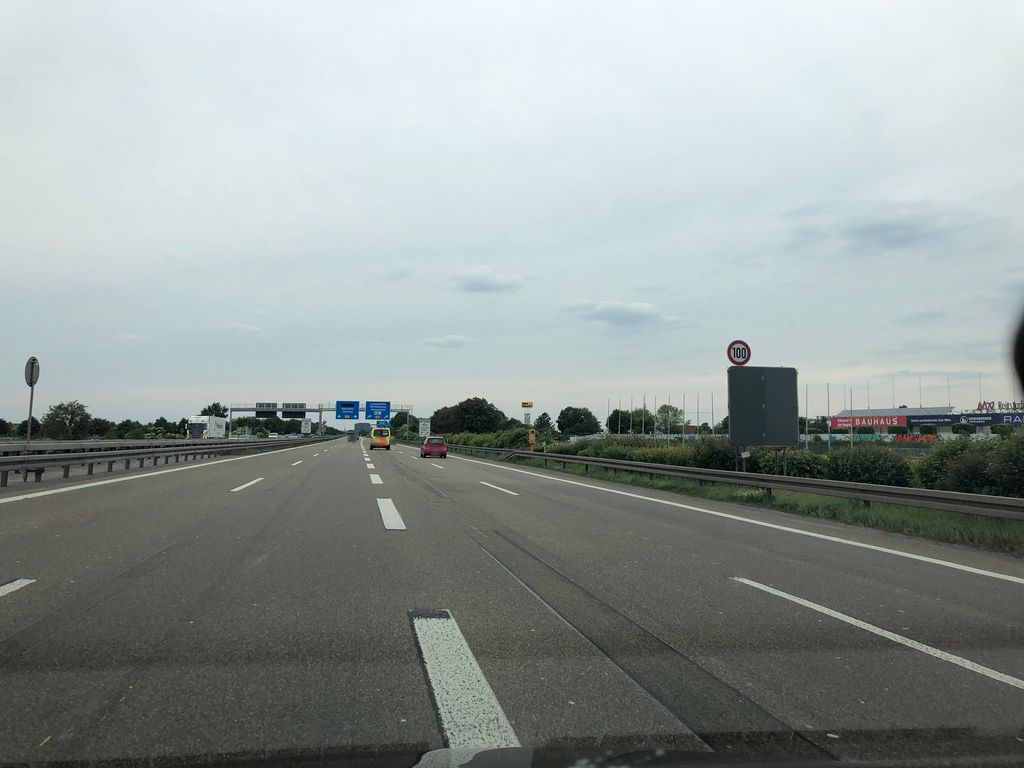
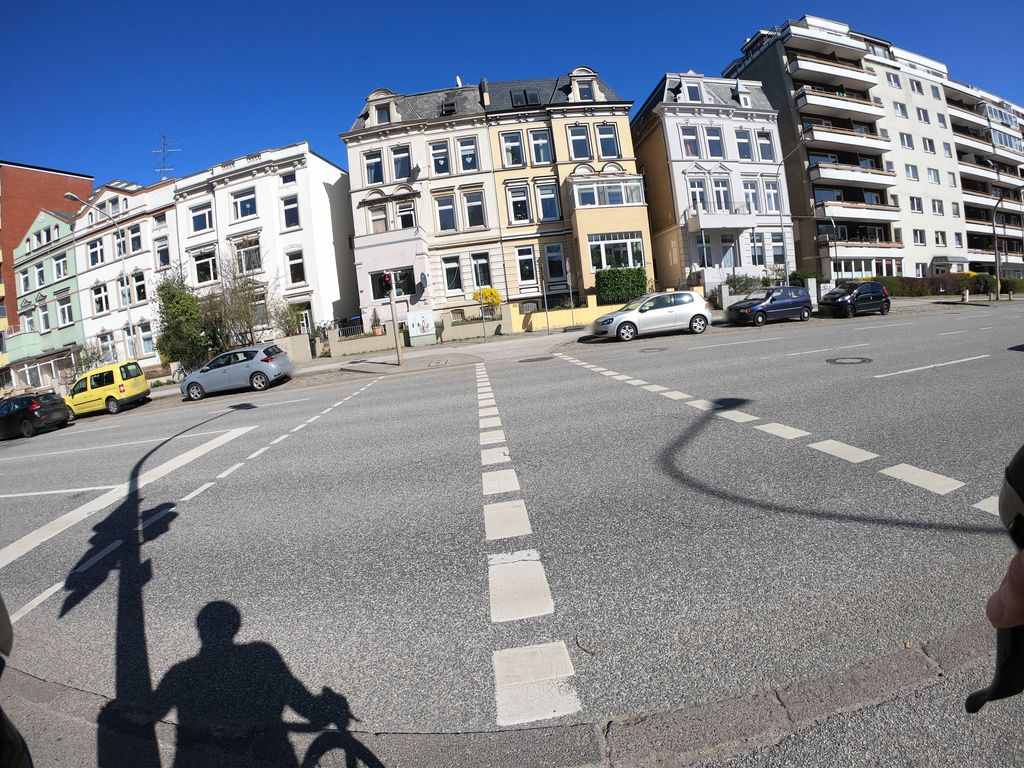
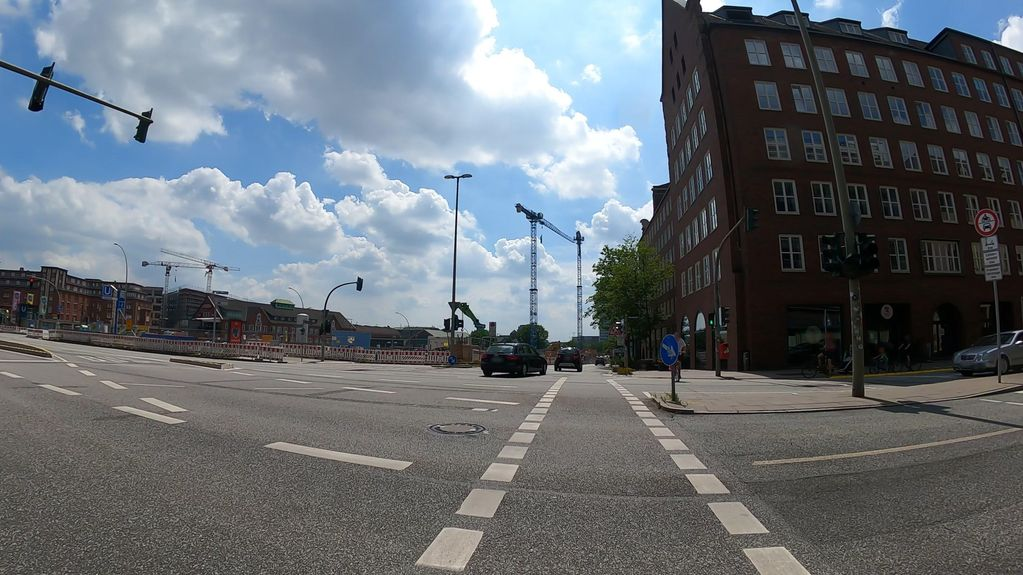
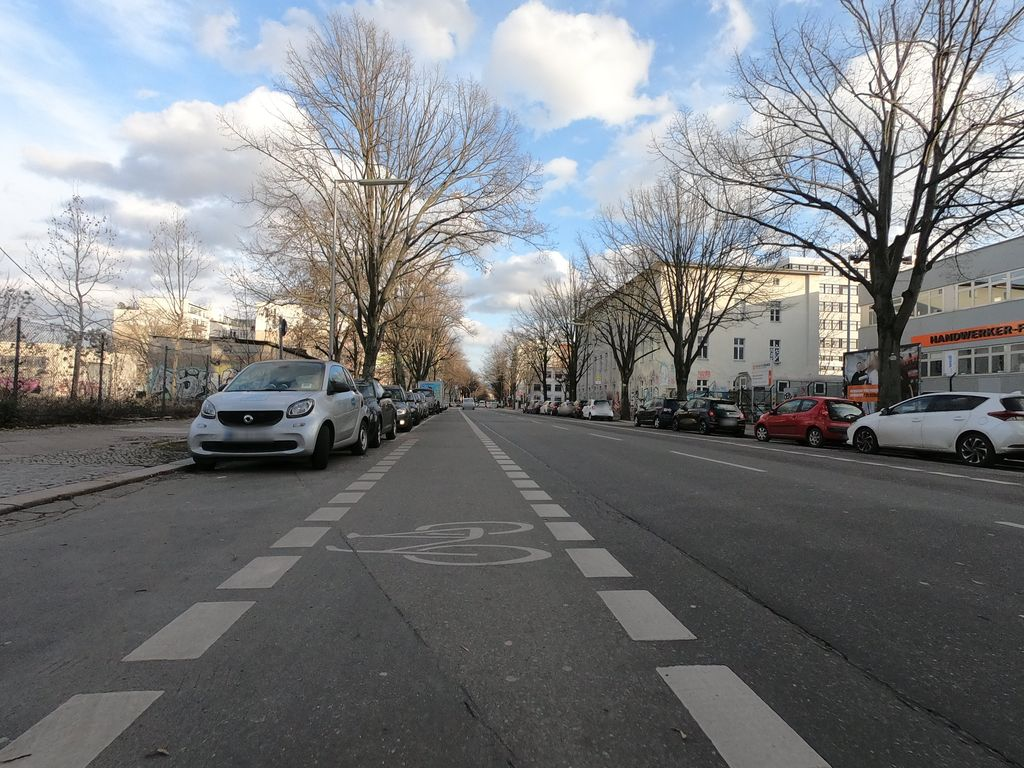

In [19]:
html_image(similar_images)

In [80]:
similar_images

[{'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/1316011592154091.jpg',
  'similarity': 0.99999994},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/paving_stones/good/170942715151562.jpg',
  'similarity': 0.90427285},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/1609107002914707.jpg',
  'similarity': 0.901222},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/good/712778106740899.jpg',
  'similarity': 0.8966453},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/574611193546310.jpg',
  'similarity': 0.896544},
 {'image': '/Users/edith/git/SurfaceAI/classification_models/src/utils/../../data/training/V11/annotated/asphalt/excellent/14816327440445